##           Programming assignment: "CNN to perform American sign language detection"
### Name : Sayyad Abdul Bari
### Roll No. :- 22566019

# Libraries that are used
- torch
- pathlib
- os
- PIL
- torchvision 
- torch.nn
- torchinfo
- tqdm.auto
- matplotlib

####  Data Preparation

In [1]:
# For using cuda
import torch
cuda=torch.device('cuda')
cuda

device(type='cuda')

In [2]:
# Defining Location Path for Data Set
from pathlib import Path
data_paths=Path("data/")
image_paths = data_paths/"american_sign_data"

In [3]:
# Making training and testing Dataset's paths  as usable for Pytorch
train_dirs = image_paths / "train_data"
test_dirs = image_paths / "test_data"
train_dirs, test_dirs

(WindowsPath('data/american_sign_data/train_data'),
 WindowsPath('data/american_sign_data/test_data'))

#### Transforming Dataset

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [5]:
# converts all pixel values from 0 to 255 to be between 0.0 and 1.0
data_transformed = transforms.Compose([transforms.ToTensor()])

####  Visualization

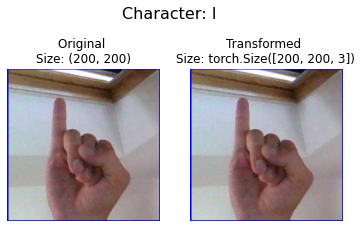

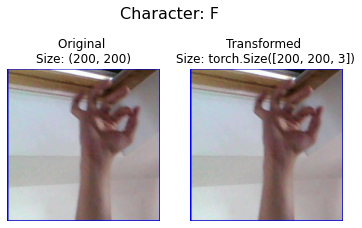

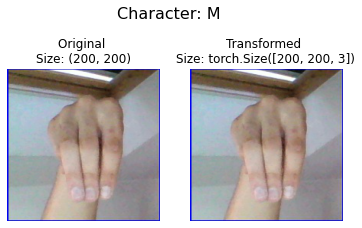

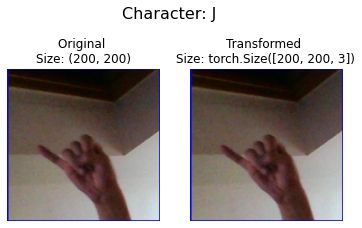

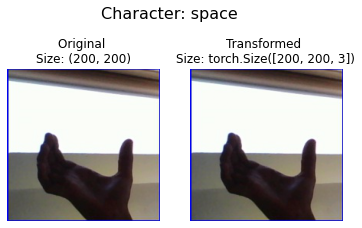

In [6]:
# A series of random images with their transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
random.seed(32)
list_image_path = list(image_paths.glob("*/*/*.jpg"))
random_image_path = random.choice(list(list_image_path))
def plot_transformed_images(image_paths, transform, no_of_samples=5):
    random_image_paths = random.sample(image_paths, k=no_of_samples)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, axis = plt.subplots(1, 2)
            axis[0].imshow(f) 
            axis[0].set_title(f"Original \nSize: {f.size}")
            axis[0].axis("off")
            transformed_image = transform(f).permute(1, 2, 0) 
            axis[1].imshow(transformed_image) 
            axis[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            axis[1].axis("off")
            fig.suptitle(f"Character: {image_path.parent.stem}", fontsize=16)
plot_transformed_images(list_image_path,data_transformed)

#### Loading Dataset

In [7]:
from torchvision import datasets
training_data = datasets.ImageFolder(train_dirs,transform=data_transformed,target_transform=None)
testing_data = datasets.ImageFolder(root=test_dirs,transform=data_transformed)
print(f"Training data:{training_data}\nTesting data:{testing_data}")

Training data:Dataset ImageFolder
    Number of datapoints: 87000
    Root location: data\american_sign_data\train_data
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Testing data:Dataset ImageFolder
    Number of datapoints: 28
    Root location: data\american_sign_data\test_data
    StandardTransform
Transform: Compose(
               ToTensor()
           )


####  Taking Character name as list and dictionary

In [8]:
character_names_list = training_data.classes

In [9]:
character_name_dict = training_data.class_to_idx

In [10]:
print(f"The length of training data:{len(training_data)}\nand length of testing data:{len(testing_data)}")

The length of training data:87000
and length of testing data:28


#### Turning Loaded images into Dataloaders

In [11]:
training_dataloader = DataLoader(dataset=training_data,batch_size=1,num_workers=1, shuffle=True)
testing_dataloader = DataLoader(testing_data,1,False,num_workers=1) # no need to shuffle testing data
training_dataloader, testing_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1b6111f6f40>,
 <torch.utils.data.dataloader.DataLoader at 0x1b6111f6f70>)

#### A CNN model containing 2 conv blocks each of block has 5 layers
#### Each layer has sequence of convolution ->ReLu -> convolution ->ReLu ->Max Pool

In [12]:
import torch.nn as nn
class conv_block_2_each_5_layer(nn.Module):
    def __init__(self, input_shape: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape,10,3,1,1),
            nn.ReLU(),
            nn.Conv2d(10,10,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(10, 10,3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10,3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
       
    
        self.classifier = nn.Sequential(
            nn.Flatten(),         
            nn.Linear(10*50*50,output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        
torch.manual_seed(42)
model = conv_block_2_each_5_layer(3,len(character_names_list)).to(cuda)

#### model summarization

In [13]:
import torchinfo
from torchinfo import summary
summary(model,[1, 3, 200, 200])

Layer (type:depth-idx)                   Output Shape              Param #
conv_block_2_each_5_layer                [1, 29]                   --
├─Sequential: 1-1                        [1, 10, 100, 100]         --
│    └─Conv2d: 2-1                       [1, 10, 200, 200]         280
│    └─ReLU: 2-2                         [1, 10, 200, 200]         --
│    └─Conv2d: 2-3                       [1, 10, 200, 200]         910
│    └─ReLU: 2-4                         [1, 10, 200, 200]         --
│    └─MaxPool2d: 2-5                    [1, 10, 100, 100]         --
├─Sequential: 1-2                        [1, 10, 50, 50]           --
│    └─Conv2d: 2-6                       [1, 10, 100, 100]         910
│    └─ReLU: 2-7                         [1, 10, 100, 100]         --
│    └─Conv2d: 2-8                       [1, 10, 100, 100]         910
│    └─ReLU: 2-9                         [1, 10, 100, 100]         --
│    └─MaxPool2d: 2-10                   [1, 10, 50, 50]           --
├─Sequentia

#### Training Setup

In [14]:
def training_steps(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fun: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(cuda), y.to(cuda) # sending data to targeted device
        y_pred = model(X)
#calculating and accumulating loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#calculating and accumulating accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
# Adjusting metrics to get average loss and accuracy per batch 
    training_loss = train_loss / len(dataloader)
    training_acc = train_acc / len(dataloader)
    return train_loss, train_acc

#### Testing Setup

In [15]:
def test_steps(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(cuda), y.to(cuda)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

#### Combining Training and Testing steps

In [16]:
from tqdm.auto import tqdm
def trained(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_steps(model,training_dataloader,loss_fn,optimizer)
        test_loss, test_acc = test_steps(model,test_dataloader,loss_fn)
        print(
            f"Epoch: {epoch+1} | "
            f"test_acc: {100*test_acc:.4f}"
        )

        results["test_acc"].append(test_acc)
    return results

In [17]:
# Seting random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)
NUM_EPOCHS = 5
model = conv_block_2_each_5_layer(input_shape=3, # number of color channels (3 for RGB) 
                  output_shape=len(training_data.classes)).to(cuda)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
# Train model
model_results = trained(model=model, 
                        train_dataloader=training_dataloader,
                        test_dataloader=testing_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

TypeError: unsupported format string passed to tuple.__format__